# Introduction to weighting and masking

When calculating mean verification scores, not all data points should always contribute equally. Depending on the projection, the physical area represented, or the region of interest, you may need to adjust the contribution of each grid cell by applying weights or masks.

To address these issues, `scores` provides a flexible way to apply weights or masks when calculating the mean scores. Weighting is handled by the function `scores.processing.aggregation`, which works similarly to xarray’s built-in weighted method.




Examples include:
- The gridded forecasts and observations aren't on an "equal area" map projection. One common map projection is the latitude-longitude projection. On this projection, the grid cells near the equator account for a much larger area than the grid cells near the poles. 
- You may want to weight the mean score by the relative importance of each point (e.g., by a population density grid, or a vulnerability grid).
- You may want to mask data over the ocean to only evaluate a forecast over land

First we will discuss weighting in more detail before moving on to masking. Weighting in the metrics in `scores` is handled by the function `scores.processing.aggregation`. To calculate a weighted score, you must supply the `weights` arg with an xr.Dataset or xr.DataArray. Our approach follows the `weighted` approach that xarray uses. See the [xarray tutorial](https://tutorial.xarray.dev/fundamentals/03.4_weighted.html) for further information.

Let's step through an example of how the weighting works. Suppose we have a 2D grid and we want to calculate the weighted mean with some weights.

First, the squared error $x_{i, j}$ at the $(i,j)$th point is calculated. If we have weights $w$, we can calculate the weighted Mean Squared Error (MSE), $\bar{x}$ as
$$
\bar{x} = \frac{\sum_{i=1}^{M} \sum_{j=1}^{N} w_{i,j} \, x_{i,j}}{\sum_{i=1}^{M} \sum_{j=1}^{N} w_{i,j}}
$$
where $i$ is a latitude for $M$ latitudes, and $j$ is the longitude for $N$ longitudes.


## Weighting example
Let’s now see how this works in practice. A common case is latitude weighting: on a latitude-longitude grid, cells closer to the poles represent smaller physical areas than those near the equator. To account for this, we can weight each grid cell by the cosine of its latitude when calculating the mean score.

In [1]:
import pandas as pd
import xarray as xr

from scores.continuous import mse
from scores.functions import create_latitude_weights

First, let's retrieve a week of GraphCast and ERA5 2m temperature data. It may take 30 seconds to connect and download the data.

In [2]:
LEAD_TIME = pd.Timedelta("2d")
START_TIME = pd.Timestamp("2020-01-01")
END_TIME = pd.Timestamp("2020-01-07")

era5 = xr.open_zarr(
    "gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-240x121_equiangular_with_poles_conservative.zarr"
)
graphcast = xr.open_zarr(
    "gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours-240x121_equiangular_with_poles_conservative.zarr"
)

In [3]:
obs = era5["2m_temperature"].sel(time=slice(START_TIME, END_TIME)).compute()

In [4]:
fcst = graphcast["2m_temperature"].sel(time=slice(START_TIME, END_TIME), prediction_timedelta=LEAD_TIME).compute()
# Update the time coords in the forecast to match up to the observations
fcst = fcst.assign_coords({"time": fcst.time + LEAD_TIME})

Let's have a look at one timestep of the observations. The data is on a latitude-longitude grid

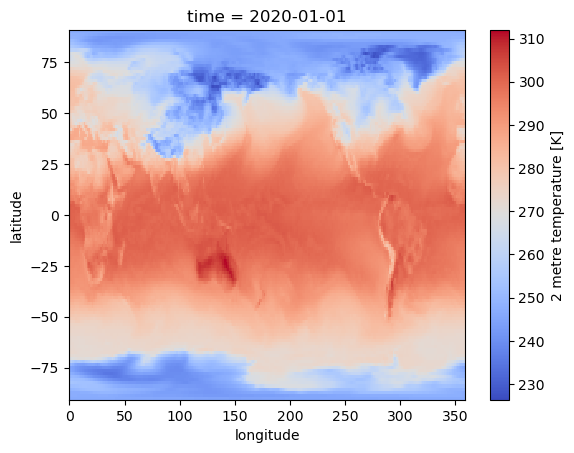

In [5]:
obs.isel(time=0).T.plot(cmap="coolwarm")

Let's calculate the MSE without any latitude weighting

In [6]:
mse(fcst, obs)

<xarray.DataArray '2m_temperature' ()> Size: 4B
array(0.61294854, dtype=float32)
Coordinates:
    prediction_timedelta  timedelta64[ns] 8B 2 days

Now let's generate some latitude weights and visualise them. They will apply a larger weight at latitudes near the equator since those grid cells comprise of a larger area. We can use the function `scores.functions.create_latitude_weights` to do this

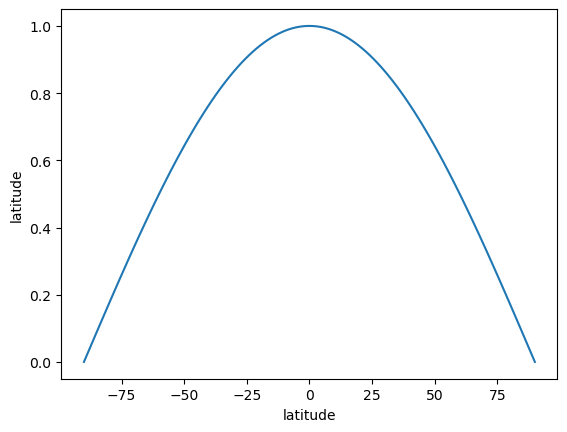

In [7]:
lat_weights = create_latitude_weights(obs.latitude)
lat_weights.plot()

`lat_weights` is a 1D weighting object, but our forecast and observation data is 3D (2D space + time). `scores` will handle this using xarray broadcasting rules. It will also correctly handle the case where there are NaNs in the forecasts or observation data.

Now let's calculate the MSE using the latitude weights

In [8]:
mse(fcst, obs, weights=lat_weights)

<xarray.DataArray '2m_temperature' ()> Size: 8B
array(0.46209789)
Coordinates:
    prediction_timedelta  timedelta64[ns] 8B 2 days

The MSE is now lower when using latitude weights compared to using no weights! To understand why, let's plot the MSE as a function of latitude.

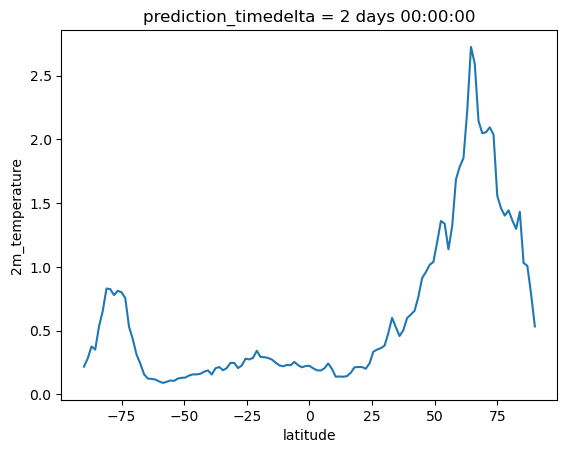

In [9]:
mse(fcst, obs, preserve_dims="latitude").plot()

The errors are lower near the equator and larger at higher latitudes. Since our weights are higher near the equator and lower at higher latitudes, weighting by latitude in this case acts to reduce the MSE.

## What if I have NaNs in my weights?
If your weight array contains NaN values, it is not always clear how these should be handled. Because different applications may require different choices, scores will raise an error rather than making an assumption for you.

In most cases, filling missing values with zeros is a sensible approach, since a weight of zero means "this grid cell does not contribute." You can do this with:
```python
weights = weights.fillna(0)
```

To demonstrate why this is the case, imagine that we have 3 points and we want to calculate a weighted mean. Let's say that our errors array is $x=[1, 3, 5]$. Now suppose that our weights array is $w=[3, 1, \mathrm{NaN}]$. We expect in this case that the weighted mean should only consist of the first two points and give us a weighted mean of 1.5. Let's step through this:
1. Make the NaN value in the weights 0, so that our weights are [3, 1, 0]
2. Calculate the weighted mean as

$$\mu_w = \frac{\sum_{i=1}^{n} w_i x_i}{\sum_{i=1}^{n} w_i} = \frac{1 \times 3 + 3 \times 1 + 5 \times 0}{3 + 1 + 0}=\frac{6}{4}=1.5$$


## Masking example
Suppose we want to mask the results over the tropics (within 23.5 degrees of the equator), we could either preprocess our forecast and observation data with a mask, or alternatively we can use the `weights` arg to create a mask. A mask can be created by assigning values of 0 to where we don't want those points contributing to the mean score and values of 1 that we want to include in the contribution of the mean score. Let's mask the tropics and calculate the MSE

In [10]:
tropics_mask = ((obs.latitude > 23.5) | (obs.latitude < -23.5)).astype(int)
tropics_mask

<xarray.DataArray 'latitude' (latitude: 121)> Size: 968B
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Coordinates:
  * latitude  (latitude) float64 968B -90.0 -88.5 -87.0 -85.5 ... 87.0 88.5 90.0

In [11]:
mse(fcst, obs, weights=tropics_mask)

<xarray.DataArray '2m_temperature' ()> Size: 8B
array(0.74780581)
Coordinates:
    prediction_timedelta  timedelta64[ns] 8B 2 days

This masking didn't weight the score by the size of each grid cell. We can combine our latitude weights above with our mask and calculate the MSE.

In [12]:
lat_weights_tropics_mask = lat_weights * tropics_mask
mse(fcst, obs, weights=lat_weights_tropics_mask)

<xarray.DataArray '2m_temperature' ()> Size: 8B
array(0.61935568)
Coordinates:
    prediction_timedelta  timedelta64[ns] 8B 2 days

## Weighting data directly

Some users may want to apply the weighting function themselves after preserving all dimensions when calculating the score. This could occur when calculating confidence intervals or wanting to calculate the mean one dimension at a time in a specific order when there are NaNs in the data.

`scores` makes the function used under the hood in each metric (`scores.processing.aggregate`) available to use. Let's demonstrate this by repoducing the latitude weighted MSE in two steps.

In [13]:
from scores.processing import aggregate

In [14]:
# First calculate the squared error at each point
se = mse(fcst, obs, preserve_dims="all")
lat_weighted_mse = aggregate(se, reduce_dims=["time", "latitude", "longitude"], weights=lat_weights)
lat_weighted_mse

<xarray.DataArray '2m_temperature' ()> Size: 8B
array(0.46209789)
Coordinates:
    prediction_timedelta  timedelta64[ns] 8B 2 days

We can show that the following two are equal

In [15]:
xr.testing.assert_equal(lat_weighted_mse, mse(fcst, obs, weights=lat_weights))

The behaviour of `scores.processing.aggregate` is as follows:
-  If `reduce_dims` is None, no aggregation is performed and the original values are
    returned unchanged.
-  If `weights` is None, an unweighted mean is computed. If weights are provided, negative
    weights are not allowed and will raise a `ValueError`.
-  If weights are provided but `reduce_dims` is None (i.e., no reduction), a `UserWarning`
    is emitted since the weights will be ignored

There is also a `method` arg which takes `"mean"` (default) or `"sum"`. In most cases `"mean"` is appropriate for weighted aggregations. `method="sum"` can also be used for producing weighted sums. A use case for `method="sum"` is when calculating a weighted contingency table score such as probability of detection. In this case a weighted sum is applied to the misses and the hits, before calculating the probability of detection.

## Things to try next
- Try and calculate weighted scores with methods other than MSE
- Download a population density grid and create a mean score weighted by population density.